<a href="https://colab.research.google.com/github/mahapara2411/devopsgit/blob/main/Pareto_NBD_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 5.1 MB/s 


In [2]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import plotly.express as px
import xlrd
import pandas as pd
import warnings
import lifetimes
import dill as pickle
from sklearn.cluster import KMeans
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt
warnings.filterwarnings("ignore")
import datetime
np.random.seed(42)

In [3]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [4]:
data["Total Amount"] = data["Quantity"]*data["Price"]

In [5]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Total Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [6]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "Total Amount")

In [7]:
rfm_summary.reset_index(inplace = True)

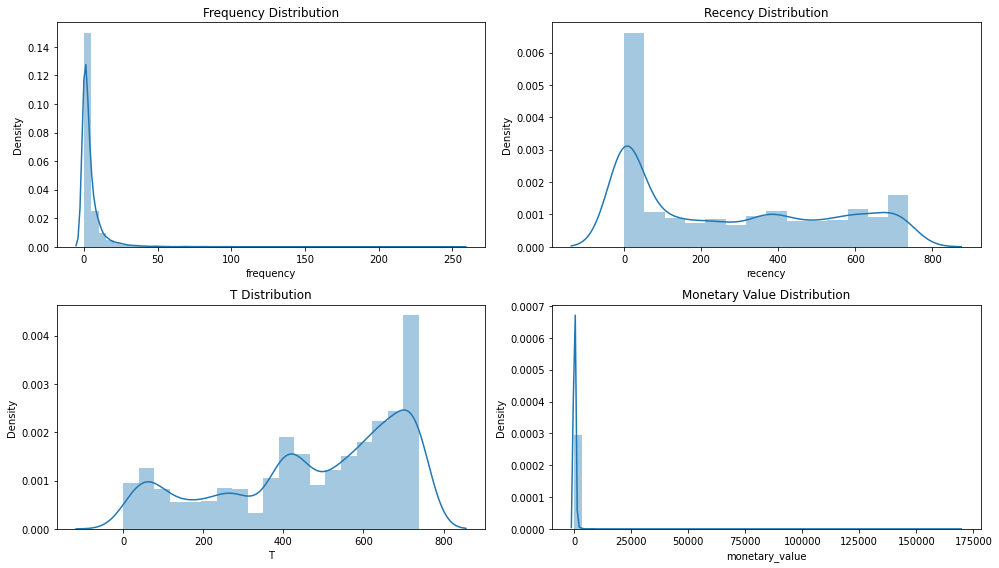

In [8]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

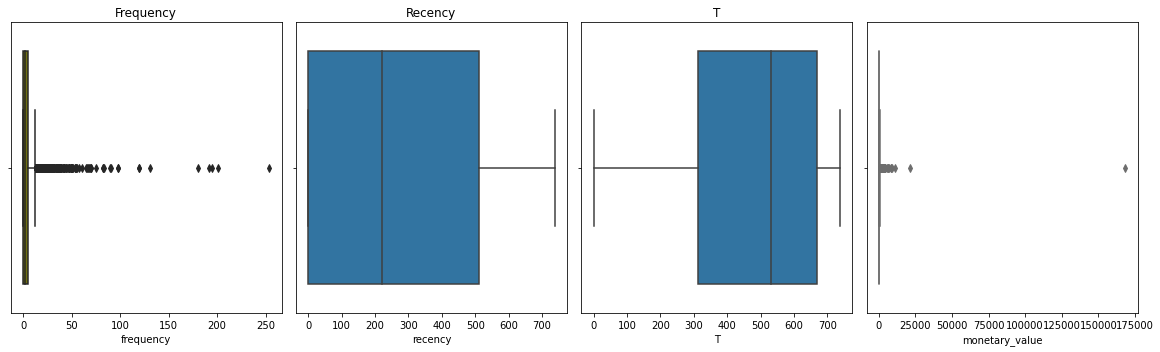

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "salmon")

plt.tight_layout()

In [10]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,4.632358,273.393671,474.260463,312.996109
std,1715.572666,9.999783,258.964160,223.090893,2255.743188
min,12346.000000,0.000000,0.000000,0.000000,0.000000
1%,12405.770000,0.000000,0.000000,15.000000,0.000000
10%,12936.700000,0.000000,0.000000,89.000000,0.000000
25%,13833.250000,0.000000,0.000000,313.000000,0.000000
50%,15314.500000,2.000000,221.000000,530.000000,207.117500
75%,16797.750000,5.000000,512.000000,668.000000,368.045909
90%,17696.300000,11.000000,667.000000,730.000000,591.139417


In [11]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346,7.0,400.0,725.0,11066.637143
1,12347,7.0,402.0,404.0,615.714286
2,12348,4.0,363.0,438.0,449.310000
3,12349,3.0,571.0,589.0,1120.056667
4,12350,0.0,0.0,310.0,0.000000


**Pareto/NBD Model**

In [12]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 2.2178139372372287
Predicted Purchase R2 Score: 0.06087699922758316
Predicted Purchase Root Mean Squared Error: 1.489232667260972
Predicted Purchase Average Purchases Error: 0.23295069720464043


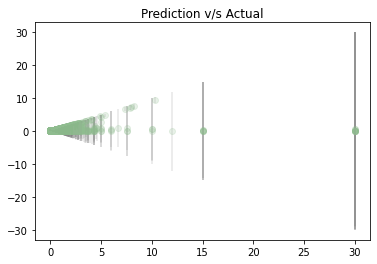

In [13]:
get_model(rfm_summary, 0.001, 30)

In [14]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [15]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 5878 subjects, alpha: 71.97, beta: 383.01, r: 0.74, s: 0.18>

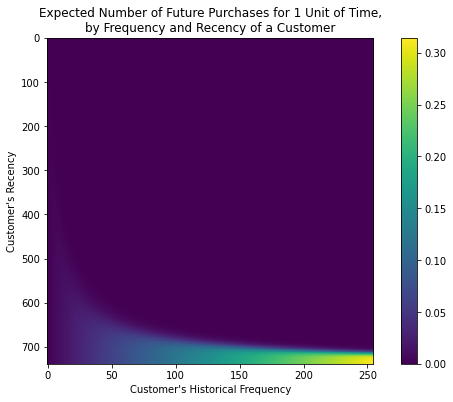

In [16]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

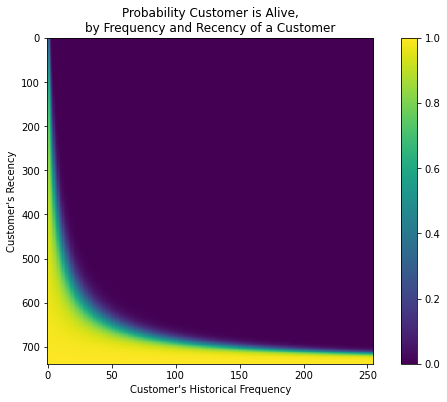

In [17]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [18]:
pareto_result = rfm_summary.copy()

In [19]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [20]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,7.0,400.0,725.0,11066.637143,0.467494,0.532506
1,12347,7.0,402.0,404.0,615.714286,0.000468,0.999532
2,12348,4.0,363.0,438.0,449.310000,0.025382,0.974618
3,12349,3.0,571.0,589.0,1120.056667,0.003559,0.996441
4,12350,0.0,0.0,310.0,0.000000,0.168506,0.831494


In [21]:
t = 30
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [22]:
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346,7.0,400.0,725.0,11066.637143,0.467494,0.532506,0.154747
1,12347,7.0,402.0,404.0,615.714286,0.000468,0.999532,0.485886
2,12348,4.0,363.0,438.0,449.310000,0.025382,0.974618,0.270807
3,12349,3.0,571.0,589.0,1120.056667,0.003559,0.996441,0.168624
4,12350,0.0,0.0,310.0,0.000000,0.168506,0.831494,0.048060
...,...,...,...,...,...,...,...,...
5873,18283,18.0,655.0,658.0,142.666667,0.000543,0.999457,0.767718
5874,18284,0.0,0.0,431.0,0.000000,0.223861,0.776139,0.034087
5875,18285,0.0,0.0,660.0,0.000000,0.310743,0.689257,0.020816
5876,18286,1.0,247.0,723.0,833.480000,0.202999,0.797001,0.052169


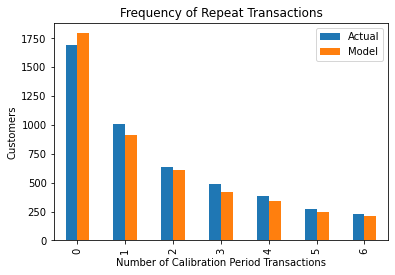

In [23]:
plot_period_transactions(pareto_model)

In [24]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [25]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,400.0,541.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [26]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 4960 subjects, alpha: 74.73, beta: 1613.00, r: 0.75, s: 0.69>

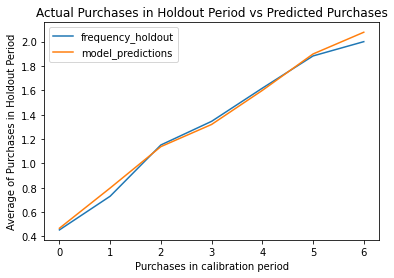

In [27]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [28]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,400.0,541.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [29]:
pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [30]:
pareto_result["actual30"].fillna(0, inplace = True)

In [31]:
pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases"]

In [32]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346,7.0,400.0,725.0,11066.637143,0.467494,0.532506,0.154747,0.525000,0.370253
1,12347,7.0,402.0,404.0,615.714286,0.000468,0.999532,0.485886,0.522388,0.036502
2,12348,4.0,363.0,438.0,449.310000,0.025382,0.974618,0.270807,0.330579,0.059771
3,12349,3.0,571.0,589.0,1120.056667,0.003559,0.996441,0.168624,0.157618,-0.011006
4,12350,0.0,0.0,310.0,0.000000,0.168506,0.831494,0.048060,0.000000,-0.048060


In [33]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    print("R2 Score: %s"%(r2_score(true, predicted)))
    
    sns.scatterplot(true, predicted, size = error, color = "darkolivegreen")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 2.2186608837182007
Root Mean Squared Error: 1.489516996787281
R2 Score: 0.06051836367779728


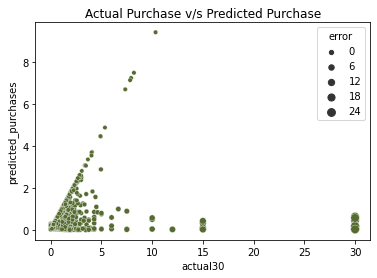

In [34]:
get_metrics(pareto_result["actual30"], pareto_result["predicted_purchases"], pareto_result["error"])

In [35]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

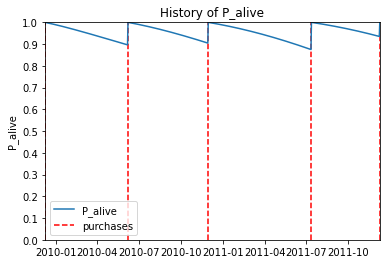

In [36]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [37]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]

In [38]:
idx = idx.index

In [39]:
ggf_filter = pareto_result.drop(idx, axis = 0)

In [40]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [41]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [42]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

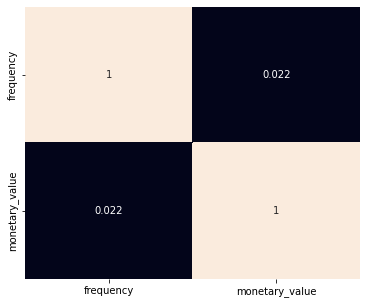

In [43]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [44]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [45]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 1.02, q: 0.18, v: 0.93>

In [46]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.019926,0.024531,0.971847,1.068006
q,0.179152,0.002996,0.173280,0.185024
v,0.933468,0.025489,0.883509,0.983426


In [47]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [48]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
0,12346,7.0,400.0,725.0,11066.637143,0.467494,0.532506,0.154747,0.525000,0.370253,12504.444266
1,12347,7.0,402.0,404.0,615.714286,0.000468,0.999532,0.485886,0.522388,0.036502,695.851827
2,12348,4.0,363.0,438.0,449.310000,0.025382,0.974618,0.270807,0.330579,0.059771,562.775336
3,12349,3.0,571.0,589.0,1120.056667,0.003559,0.996441,0.168624,0.157618,-0.011006,1531.122707
6,12352,8.0,356.0,392.0,338.261250,0.012395,0.987605,0.556117,0.674157,0.118040,376.226883


In [49]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Mean Squared Error: 118446913.1865241
Root Mean Squared Error: 10883.331897287893
R2 Score: -15.7218443394684


In [50]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [51]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
4061,16446,3.633822e+06
5692,18102,5.051211e+05
2277,14646,4.539489e+05
189,12536,3.623747e+05
5050,17450,2.874320e+05


In [52]:
# Assuming 5% of Profit Margin
ggf_filter["profit_margin"] = ggf_filter["predicted_clv"]*0.05

In [53]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [54]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

**CUSTOMER SEGMENTATION USING PREDICTED CLV**

In [55]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
0,12346,7.0,400.0,725.0,11066.637143,0.467494,0.532506,0.154747,0.525000,0.370253,12504.444266,34879.040060,1743.952003
1,12347,7.0,402.0,404.0,615.714286,0.000468,0.999532,0.485886,0.522388,0.036502,695.851827,7674.091506,383.704575
2,12348,4.0,363.0,438.0,449.310000,0.025382,0.974618,0.270807,0.330579,0.059771,562.775336,3426.995339,171.349767
3,12349,3.0,571.0,589.0,1120.056667,0.003559,0.996441,0.168624,0.157618,-0.011006,1531.122707,5915.452134,295.772607
6,12352,8.0,356.0,392.0,338.261250,0.012395,0.987605,0.556117,0.674157,0.118040,376.226883,4718.890382,235.944519


In [56]:
col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv", "profit_margin"]

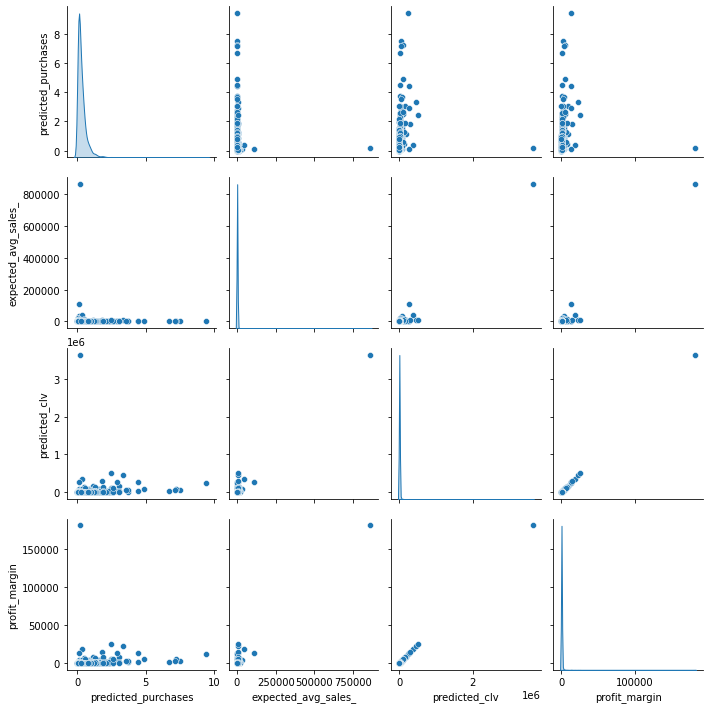

In [57]:
sns.pairplot(ggf_filter[col], diag_kind = "kde")

In [58]:
new_df = ggf_filter[col]
print(new_df)

      predicted_purchases  expected_avg_sales_  predicted_clv  profit_margin
0                0.154747         12504.444266   34879.040060    1743.952003
1                0.485886           695.851827    7674.091506     383.704575
2                0.270807           562.775336    3426.995339     171.349767
3                0.168624          1531.122707    5915.452134     295.772607
6                0.556117           376.226883    4718.890382     235.944519
...                   ...                  ...            ...            ...
5871             0.076242           418.842957     714.275644      35.713782
5872             0.261442           403.575690    2348.264792     117.413240
5873             0.767718           149.398387    2636.978499     131.848925
5876             0.052169          4274.903737    4656.490007     232.824500
5877             0.264368           741.876848    4467.648878     223.382444

[4189 rows x 4 columns]


In [59]:
inertia = []

for i in range(1, 11):
    kmeans  = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

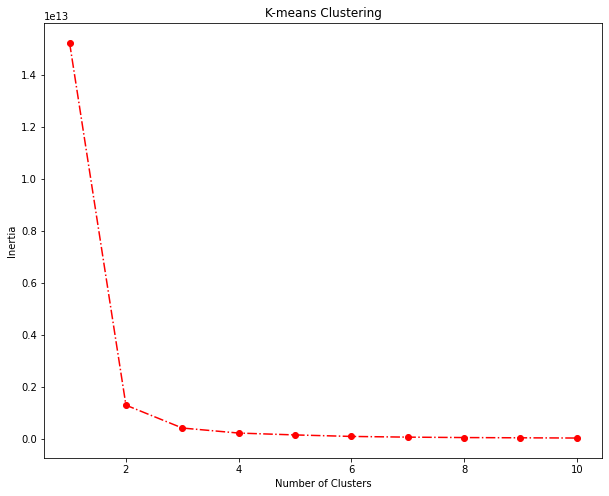

In [60]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering')
plt.show()

In [67]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [68]:
labels=kmeans.fit(new_df)

In [69]:
df_segm_kmeans= new_df.copy()
new_df['Segment K-means'] = kmeans.labels_

In [70]:
df_segm_analysis = new_df.groupby(['Segment K-means']).mean()
df_segm_analysis

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
0,0.324188,758.434538,4.102488e+03,205.124399
1,0.187483,863115.638821,3.633822e+06,181691.104281
2,3.107106,22851.828957,3.334010e+05,16670.048607
3,2.048435,4194.428777,7.971732e+04,3985.865902


In [71]:
df_segm_analysis.rename({0:'Low',
                         1:'High',
                         2:'Very High',
                         3:'Medium'})

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
Low,0.324188,758.434538,4.102488e+03,205.124399
High,0.187483,863115.638821,3.633822e+06,181691.104281
Very High,3.107106,22851.828957,3.334010e+05,16670.048607
Medium,2.048435,4194.428777,7.971732e+04,3985.865902


In [72]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'Low',
                                                                  1:'High',
                                                                  2:'Very High',
                                                                  3:'Medium'})

In [73]:
df_segm_kmeans.head()

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,0.154747,12504.444266,34879.040060,1743.952003,0,Low
1,0.485886,695.851827,7674.091506,383.704575,0,Low
2,0.270807,562.775336,3426.995339,171.349767,0,Low
3,0.168624,1531.122707,5915.452134,295.772607,0,Low
6,0.556117,376.226883,4718.890382,235.944519,0,Low


In [74]:
ggf_filter = pd.concat([ggf_filter,df_segm_kmeans['Segment K-means'],df_segm_kmeans['Labels']], axis = 1)

In [75]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,12346,7.0,400.0,725.0,11066.637143,0.467494,0.532506,0.154747,0.525000,0.370253,12504.444266,34879.040060,1743.952003,0,Low
1,12347,7.0,402.0,404.0,615.714286,0.000468,0.999532,0.485886,0.522388,0.036502,695.851827,7674.091506,383.704575,0,Low
2,12348,4.0,363.0,438.0,449.310000,0.025382,0.974618,0.270807,0.330579,0.059771,562.775336,3426.995339,171.349767,0,Low
3,12349,3.0,571.0,589.0,1120.056667,0.003559,0.996441,0.168624,0.157618,-0.011006,1531.122707,5915.452134,295.772607,0,Low
6,12352,8.0,356.0,392.0,338.261250,0.012395,0.987605,0.556117,0.674157,0.118040,376.226883,4718.890382,235.944519,0,Low


In [76]:
ggf_filter.groupby('Labels').CustomerID.count()/ggf_filter.CustomerID.count()*100

Labels
High          0.023872
Low          98.925758
Medium        0.859394
Very High     0.190976
Name: CustomerID, dtype: float64

In [77]:
ggf_filter.to_csv("Segmentation_result.csv")